In [108]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rosbag
from tqdm import tqdm
import glob, os

plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)

width = 3.487
height = width / 1.618

def to_time(timestamp):
    return timestamp.secs + 1e-9*timestamp.nsecs

path='/home/johann/Documents/PostDoc-Norlab/dev/Dominic/doughnut_autorally/data/'
file='PlatformA_2016-06-09-16-07-44_no_images.bag'

wheelbase=.57

os.chdir(path)
files = list(glob.glob("*.bag"))


In [89]:
cols = ['t', 'v_rf', 'v_rb', 'v_lf', 'v_lb', 'steering', 'angular_v']

df = pd.DataFrame(columns=cols)

for file in tqdm(files):
    bag = rosbag.Bag(files[0])
    df_ = pd.DataFrame(columns=cols)

    gen = bag.read_messages(topics=['/wheelSpeeds'])
    msgs = list(gen)
    df_['t'] = [to_time(msg.timestamp) for msg in msgs]
    df_['v_rf'] = [msg.message.rfSpeed for msg in msgs]
    df_['v_rb'] = [msg.message.rbSpeed for msg in msgs]
    df_['v_lf'] = [msg.message.lfSpeed for msg in msgs]
    df_['v_lb'] = [msg.message.lbSpeed for msg in msgs]

    df_['linear_v'] = .25*(df_['v_rf'] + df_['v_rb'] + df_['v_lf'] + df_['v_lb'])

    gen = bag.read_messages(topics=['/servoStatus'])
    msgs = list(gen)
    steerings = np.zeros((len(df_)))
    
    k=0
    for i in range(len(df_)):
        t = df_.loc[i]['t']
        while k < len(msgs) and to_time(msgs[k].timestamp) < t:
            k+=1
        k-=1
        steerings[i] = msgs[k].message.steering
    df_['steering'] = steerings

    df_['angular_v'] = df_['linear_v'] * np.tan(df_['steering']) / wheelbase

    df = pd.concat([df, df_], ignore_index=True)
    

100%|██████████| 15/15 [00:46<00:00,  3.09s/it]


In [153]:
print("saving data ({} points)".format(len(df)))
df.to_csv("autorally_velocities.csv") 

saving data (89760 points)


filtered 450 data points


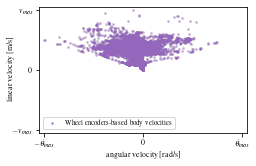

In [157]:
plt.figure(figsize=(10,10))
ax = plt.gca()
fig = plt.gcf()

df_filtered = df[(df.linear_v < 25)] #Super weird ultra large values on linar velocity
print("filtered {} data points".format(len(df)-len(df_filtered)))

max_lv = max(np.abs(df_filtered['linear_v']))
max_av = max(np.abs(df_filtered['angular_v']))


meas = ax.scatter(df_filtered['angular_v']/max_av, df_filtered['linear_v']/max_lv, 
                  c = 'tab:purple', 
                  cmap = 'hot', 
                  alpha = 0.05, 
                  lw=0, 
                  s=5,
                  label='Wheel encoders-based body velocities',
                 rasterized=True)

ax.set_ylabel('linear velocity [m/s]', labelpad=-2)
ax.set_xlabel('angular velocity [rad/s]')

leg = plt.legend(fontsize=7, loc='best')
for lh in leg.legendHandles: 
    lh.set_alpha(1)

ax.set_xlim(-1.05,1.05)
ax.set_ylim(-1.05,1.05)

ax.set_xticks([-1,0,1])
ax.set_yticks([-1,0,1])
ax.set_xticklabels([r'$-\dot{\theta}_{max}$', '0', r'$\dot{\theta}_{max}$'])
ax.set_yticklabels([r'$-v_{max}$', '0', r'$v_{max}$'])

fig.subplots_adjust(left=.15, bottom=.17, right=.98, top=.98)
fig.set_size_inches(width, height)

plt.savefig('../autorally_velocities.pdf', dpi=500)